# Summary
This script is used to plot the two dimensional T-SNE representation of a pre-trained model.

It utilizes the output of last convolutional layer, creating bottleneck with 1024 features using global Average/MAX pooling.

In [1]:
import os
from time import time

import keras
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

c:\users\czho9\anaconda3\envs\tsf\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
# Parameters to be changed

"""
Model Parameter
Since this script does not require anything beyond convolutional layer, we can just use the pre-trained one
In the future if we are going to test fine-tuned model, I will modify this script
"""
ModelInit = keras.applications.inception_v3.InceptionV3

model_preprocess_func = keras.applications.inception_v3.preprocess_input
INPUT_SHAPE = (299,299,3)
# VGG16 probably wants this to be 1
RESCALE_VALUE = 1./255
# Might have to keep this slow if the INPUT_SHAPE is large
BATCH_SIZE = 32
# Either 'avg' or 'max'
POOLING = 'avg'
SEED = 5703

"""
Images Parameter
The one that is used to generate conv output array
No need to split into train/val, as we are not doing any training with it
"""
IMAGE_DIR = r'D:\capstone\dataset\similar_10calss\FGVC_similar_10class_200'

"""
Directory of the Convolutional output file, 
better to have so the pre-computed numpy array we don't have to rerun the predicition every single time
if the file not exist in the directory, this script will simply save the conv output in the pre-determined path
Name of the file will be generated based on the model name, subset name, and input shape
"""
# If YOLO is used, just call it something like SS2-YOLO (anything without space or underscore)
SS_NAME = r'SS2'
CONV_OUTPUT_DIR = r'D:\capstone\T-SNE_result_similar'

In [12]:
# Filepath generator
# CONV_OUTPUT_FILENAME = '_'.join([ModelInit.__name__, SS_NAME, str(INPUT_SHAPE[0]), str(INPUT_SHAPE[1])]) + '.npy'
# CONV_LABEL_FILENAME = '_'.join([ModelInit.__name__, SS_NAME, str(INPUT_SHAPE[0]), str(INPUT_SHAPE[1])]) + '_label.npy'
# CONV_TSNE_FILENAME = '_'.join([ModelInit.__name__, SS_NAME, str(INPUT_SHAPE[0]), str(INPUT_SHAPE[1])]) + '_tsne.npy'
CONV_OUTPUT_FILENAME = '_'.join([ModelInit.__name__, str(INPUT_SHAPE[0]), str(INPUT_SHAPE[1])]) + '.npy'
CONV_LABEL_FILENAME = '_'.join([ModelInit.__name__, str(INPUT_SHAPE[0]), str(INPUT_SHAPE[1])]) + '_label.npy'
CONV_TSNE_FILENAME = '_'.join([ModelInit.__name__, str(INPUT_SHAPE[0]), str(INPUT_SHAPE[1])]) + '_tsne.npy'
CONV_OUTPUT_PATH = os.path.join(CONV_OUTPUT_DIR, CONV_OUTPUT_FILENAME)
CONV_LABEL_PATH = os.path.join(CONV_OUTPUT_DIR, CONV_LABEL_FILENAME)
CONV_TSNE_PATH = os.path.join(CONV_OUTPUT_DIR, CONV_TSNE_FILENAME)

In [9]:
# No need to do any prediction if the output is already saved
# Generating a prediction result array, with the size of (num_images, last_convolutional_layer_depth)
if os.path.isfile(CONV_OUTPUT_PATH):
    X = np.load(CONV_OUTPUT_PATH)
    y = np.load(CONV_LABEL_PATH)
else:
    # Loading model, the slow process
    model_notop = ModelInit(include_top=False, weights='imagenet', input_shape=INPUT_SHAPE, pooling=POOLING)
    
    # Generator preparation
    datagen = ImageDataGenerator(rescale=RESCALE_VALUE)
    #datagen.preprocessing_function = model_preprocess_func
    generator = datagen.flow_from_directory(IMAGE_DIR,
                                            target_size=INPUT_SHAPE[:2],
                                            class_mode='categorical',
                                            batch_size=BATCH_SIZE,
                                            shuffle=False,
                                            seed=SEED)
    # Predicting 3k images is slow, don't run this without GPU
    X = model_notop.predict_generator(generator)
    # Only works if shuffle is false, cos gene
    y = generator.classes
    np.save(CONV_OUTPUT_PATH, X)
    np.save(CONV_LABEL_PATH, y)

Found 2000 images belonging to 10 classes.


In [13]:
"""
Scale and visualize the embedding vectors
Based from: 
http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py
With a lot of modification
"""
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    
    classes = np.unique(y)
    plt.figure(figsize=(20,20))
    scatter_paths = [None] * len(classes)
    # Plot each classes separately, so we can make the legend properly 
    for c in classes:
        idx = np.where(y==c)
        scatter_paths[c] = plt.scatter(X[idx][:,0], X[idx][:,1],s=160)

    plt.legend(scatter_paths,
           os.listdir(IMAGE_DIR),
           scatterpoints=1,
           ncol=1,
           fontsize=16,
           bbox_to_anchor=(1, 1))

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title, fontsize=24)

time taken 76.35718989372253


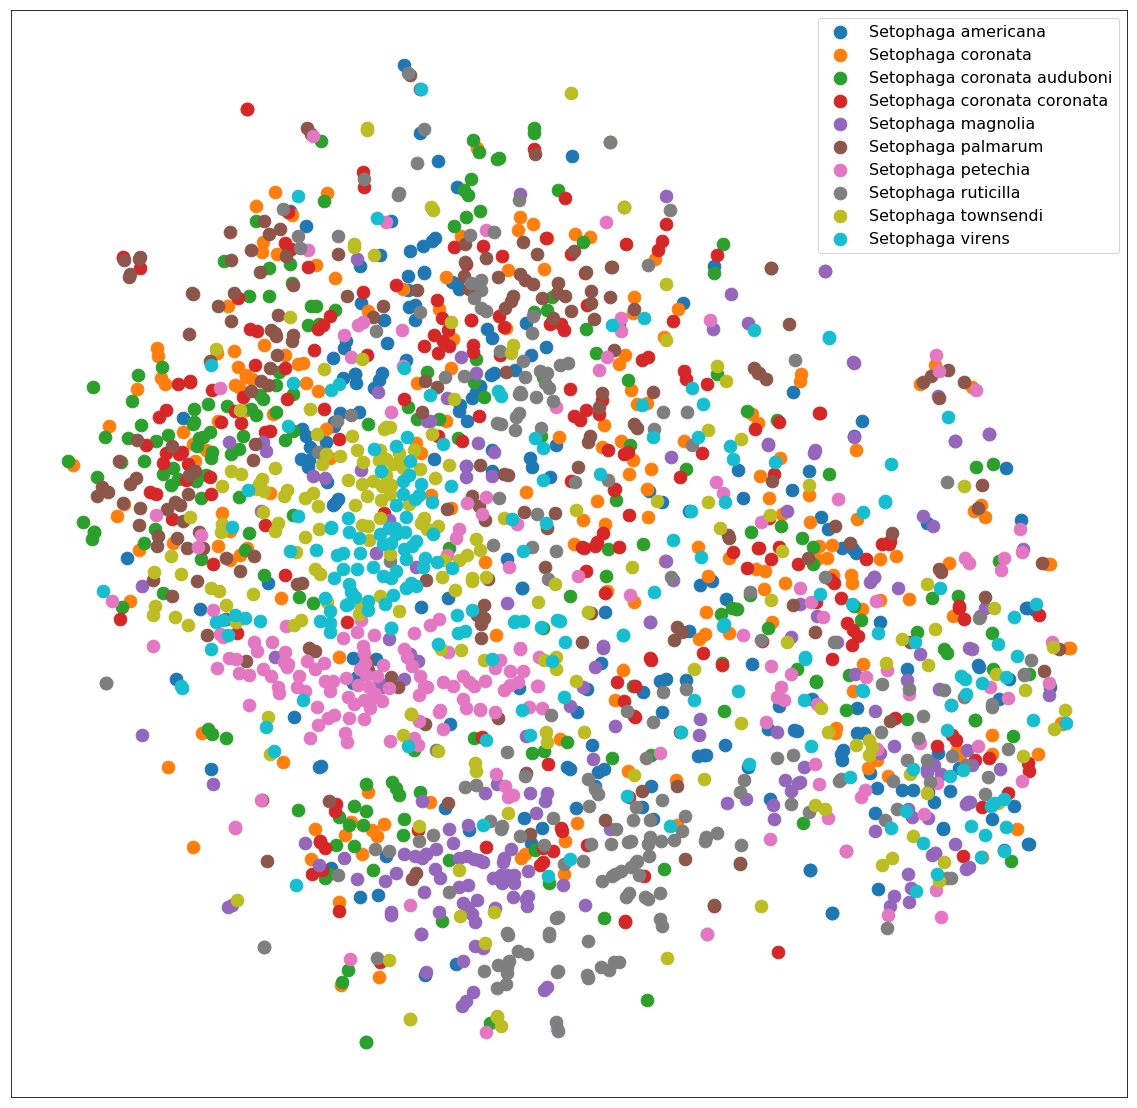

In [14]:
if os.path.isfile(CONV_TSNE_PATH):
    X_tsne = np.load(CONV_TSNE_PATH)
else:
    # This function is slow if called on large amount of data, make sure to save the image
    tsne = TSNE(n_components=2, init='pca', random_state=SEED)
    t0 = time()
    X_tsne = tsne.fit_transform(X)
    print('time taken', (time() - t0))
plot_embedding(X_tsne, y)
# plot_embedding(X_tsne, y, 
#               "t-SNE embedding of the " + SS_NAME)
plt.show()